# Subpockets to target residue(s)

We explore the distance of the `kissim` subpocket centers to their target residues.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from opencadd.databases.klifs import setup_remote

from kissim.encoding import FingerprintGenerator

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/"
RESULTS = HERE / "../../results/all"

In [5]:
REMOTE = setup_remote()

## Load subpocket center coordinates

In [6]:
fingerprint_generator = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")
# NBVAL_CHECK_OUTPUT

Number of fingerprints: 4623


In [7]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_centers = subpocket_centers.stack(0)
subpocket_centers.index.names = ("structure.klifs_id", "subpocket")
subpocket_centers = subpocket_centers.reset_index()
subpocket_centers["residue.ix"] = 0
subpocket_centers

dimension,structure.klifs_id,subpocket,x,y,z,residue.ix
0,1,center,0.783500,22.267733,37.174877,0
1,1,dfg_region,7.576667,23.035334,34.537666,0
2,1,front_pocket,1.165333,17.645666,39.785000,0
3,1,hinge_region,1.416667,23.411001,41.720001,0
4,2,center,1.191702,20.817879,37.386288,0
...,...,...,...,...,...,...
18454,13735,hinge_region,1.860000,21.551666,41.841335,0
18455,13740,center,1.299214,20.928894,36.245056,0
18456,13740,dfg_region,7.860000,20.729000,34.201668,0
18457,13740,front_pocket,0.370667,16.046333,39.406334,0


## Define target residues

In [8]:
subpocket_to_residue_ixs = {
    "hinge_region": [46, 47, 48],
    "dfg_region": [81, 82, 83],
    "front_pocket": [4, 5, 6, 7, 8, 9],
}
subpocket_to_residue_ixs

{'hinge_region': [46, 47, 48],
 'dfg_region': [81, 82, 83],
 'front_pocket': [4, 5, 6, 7, 8, 9]}

In [9]:
residue_ix_to_subpocket = {
    residue_ix: subpocket
    for subpocket, residue_ixs in subpocket_to_residue_ixs.items()
    for residue_ix in residue_ixs
}
residue_ix_to_subpocket

{46: 'hinge_region',
 47: 'hinge_region',
 48: 'hinge_region',
 81: 'dfg_region',
 82: 'dfg_region',
 83: 'dfg_region',
 4: 'front_pocket',
 5: 'front_pocket',
 6: 'front_pocket',
 7: 'front_pocket',
 8: 'front_pocket',
 9: 'front_pocket'}

## Load pocket residue CA atom coordinates

In [10]:
ca_atoms = pd.read_csv(
    DATA / "processed/pocket_residue_ca_atom_coordinates.csv.gz", header=0, index_col=[0, 1]
)
# Rename a few columns and reset index
ca_atoms = ca_atoms.rename(columns={"atom.x": "x", "atom.y": "y", "atom.z": "z"})
ca_atoms = ca_atoms.reset_index()
# Keep only target residues
ca_atoms = ca_atoms[ca_atoms["residue.ix"].isin(residue_ix_to_subpocket.keys())]
# Add subpocket name
ca_atoms["subpocket"] = ca_atoms.apply(lambda x: residue_ix_to_subpocket[x["residue.ix"]], axis=1)
# Keep only structures that we have subpocket centers for
ca_atoms = ca_atoms[
    ca_atoms["structure.klifs_id"].isin(subpocket_centers["structure.klifs_id"].unique())
]
ca_atoms

,structure.klifs_id,residue.ix,x,y,z,subpocket
3,3833,4,3.487,11.680,43.579,front_pocket
4,3833,5,6.188,10.086,41.434,front_pocket
5,3833,6,5.018,9.936,37.800,front_pocket
6,3833,7,6.529,10.561,34.362,front_pocket
7,3833,8,10.277,10.733,35.145,front_pocket
...,...,...,...,...,...,...
438581,7219,47,-0.478,23.541,46.525,hinge_region
438582,7219,48,-3.728,21.939,45.542,hinge_region
438615,7219,81,2.003,19.768,33.851,dfg_region
438616,7219,82,3.749,21.637,31.096,dfg_region


## Concatenate CA atom and subpocket center data

In [11]:
coordinates = (
    pd.concat([ca_atoms, subpocket_centers])
    .sort_values(["structure.klifs_id", "subpocket"])
    .reset_index(drop=True)
)
coordinates.index.name = "ix"
coordinates

,structure.klifs_id,residue.ix,x,y,z,subpocket
ix,,,,,,
0,1,0,0.783500,22.267733,37.174877,center
1,1,81,0.495000,19.480000,32.809000,dfg_region
2,1,82,3.266000,17.284000,34.243000,dfg_region
3,1,83,5.132000,16.924000,30.908000,dfg_region
4,1,0,7.576667,23.035334,34.537666,dfg_region
...,...,...,...,...,...,...
56547,13740,0,0.370667,16.046333,39.406334,front_pocket
56548,13740,46,0.505000,26.182000,43.555000,hinge_region
56549,13740,47,-0.600000,23.058000,45.492000,hinge_region


## Get vector between subpocket centers and their target residue CA atoms

In [12]:
vectors = coordinates.groupby(["structure.klifs_id", "subpocket"]).apply(
    lambda group: group[group["residue.ix"] != 0][["x", "y", "z"]]
    - group[group["residue.ix"] == 0][["x", "y", "z"]].squeeze()
)
vectors = (
    vectors.reset_index()
    .merge(coordinates.reset_index()[["ix", "residue.ix"]], how="left", on="ix")
    .set_index(["structure.klifs_id", "subpocket", "residue.ix"])
    .drop("ix", axis=1)
)
vectors

x         y         z
structure.klifs_id subpocket    residue.ix                               
1                  dfg_region   81          -7.081667 -3.555334 -1.728666
                                82          -4.310667 -5.751334 -0.294666
                                83          -2.444667 -6.111334 -3.629666
                   front_pocket 4            6.476667 -2.891666  4.076000
                                5            9.694667 -3.674666  2.196000
...                                               ...       ...       ...
13740              front_pocket 8           12.727333 -1.450333 -4.669334
                                9           12.419333 -1.222333 -0.907334
                   hinge_region 46          -1.476667  4.341668  1.819332
                                47          -2.581667  1.217668  3.756332
                                48          -5.906667 -0.609332  3.320332

[38093 rows x 3 columns]

## Get vector length (distance)

In [13]:
distances = vectors.apply(lambda x: np.linalg.norm(x), axis=1)
distances = distances.unstack(0).transpose()
distances

subpocket          dfg_region                     front_pocket             \
residue.ix                 81        82        83           4          5    
structure.klifs_id                                                          
1                    8.110407  7.193505  7.516600     8.180631  10.597743   
8                    6.393397  8.394686  6.744004     7.559248   9.617310   
11                   7.237975  8.515901  6.093379     8.357121  10.724409   
15                   7.151968  8.723244  8.077608     9.000510   9.633533   
19                   6.354115  6.490902  6.489961     7.522019   9.279822   
...                       ...       ...       ...          ...        ...   
13710                5.466981  5.941997  4.345430     7.307349   9.944001   
13713                5.627692  5.928676  4.076762     7.327364  10.053445   
13714                5.482859  5.958040  4.338903     7.330485   9.958515   
13724                5.522216  5.931796  4.140395     7.336034   9.986932   
13740                6.305268  6.283243  4.710864     6.561534   9.128367   

subpocket                                                      hinge_region  \
residue.ix                 6          7          8          9            46   
structure.klifs_id                                                            
1                         NaN  11.408242  13.840989  13.290591     4.977981   
8                    9.839860        NaN        NaN  10.673312     5.121003   
11                  12.973671  14.884654  12.919863  12.291550     5.196987   
15                   7.539253   9.834125  11.270214  11.669971     4.710091   
19                  10.320615        NaN        NaN   9.469290     4.727646   
...                       ...        ...        ...        ...          ...   
13710               10.818610  13.296931  11.114940  11.508710     5.252067   
13713               10.742465  12.958135  10.703858  11.459683     5.296713   
13714               10.807668  13.230398  10.969661  11.587568     5.221845   
13724               10.646629  13.027222  10.873999  11.634308     5.219321   
13740               10.388409  13.834132  13.634191  12.512282     4.933619   

subpocket                               
residue.ix                47        48  
structure.klifs_id                      
1                   4.987418  6.200912  
8                   5.351008  6.489459  
11                  5.194417  6.448320  
15                  5.085317  6.340704  
19                  4.881532  6.352533  
...                      ...       ...  
13710               5.134414  7.139480  
13713               5.203402  7.121871  
13714               5.113042  7.078682  
13724               5.091276  7.086288  
13740               4.717812  6.803279  

[3271 rows x 12 columns]

## Plot distance distributions

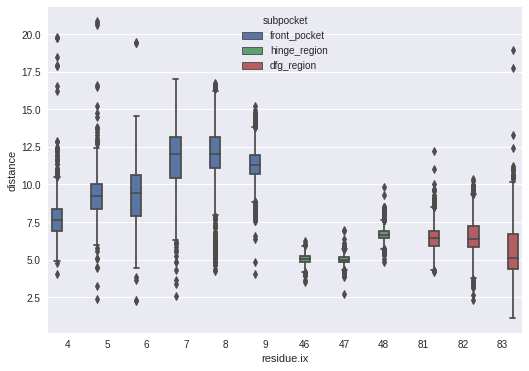

In [14]:
plt.figure(figsize=(8.5, 6))
ax = sns.boxplot(
    x="residue.ix",
    y="distance",
    hue="subpocket",
    data=distances.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
)

## Plot distance distributions split by DFG conformation

In [15]:
structures = REMOTE.structures.all_structures()

In [16]:
structure_klifs_ids_by_dfg = {
    name: group["structure.klifs_id"].to_list()
    for name, group in structures.groupby("structure.dfg")
}
distances_dict = {
    "All": distances,
    "DFG-in": distances[distances.index.isin(structure_klifs_ids_by_dfg["in"])],
    "DFG-out": distances[distances.index.isin(structure_klifs_ids_by_dfg["out"])],
}

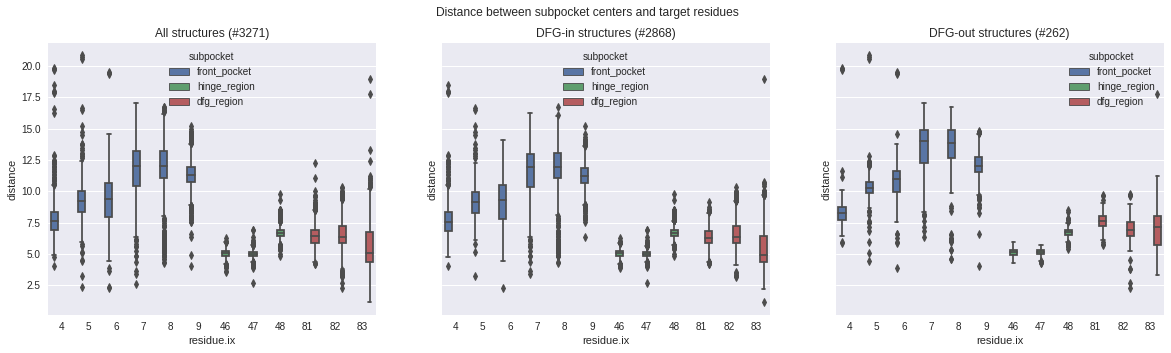

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle("Distance between subpocket centers and target residues")
for i, (title, data) in enumerate(distances_dict.items()):
    sns.boxplot(
        x="residue.ix",
        y="distance",
        hue="subpocket",
        data=data.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
        ax=axes[i],
    )
    axes[i].set_title(f"{title} structures (#{len(data)})")